In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
import rgan
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

model_number = 2

In [3]:
IN_SHAPE, DELTA = 0, 0
if model_number == 1: 
    IN_SHAPE += 75
    DELTA = config["resolution"]
    seeing = config["seeing_1"]
elif model_number == 2: 
    IN_SHAPE += 64
    DELTA = config["resolution_2"]
    seeing = config["seeing_2"]
else: 
    IN_SHAPE += 64
    DELTA = config["resolution_3"]
    seeing = config["seeing_3"]
MAGNIFICATION = config["magnification"]
N_MAG = config["n_magnification"]

alpha_t_scaling = config["alpha_t_scaling"]

alpha_bounds = [config["alpha_l"],config["alpha_h"]]
alpha_signs = torch.tensor([-1 for _ in range(IN_SHAPE)]+[1 for __ in range(IN_SHAPE)])

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

def variation_density_loss(alpha):
        diff_x = torch.abs(alpha[:, :, 1:, :] - alpha[:, :, :-1, :])#/((alpha[:, :, 1:, :] + alpha[:, :, :-1, :])/2))
        diff_y = torch.abs(alpha[:, :, :, 1:] - alpha[:, :, :, :-1])#/((alpha[:, :, :, 1:] + alpha[:, :, :, :-1])/2))
        return torch.sum(diff_x)/(diff_x.shape[2]*diff_x.shape[3]) + torch.sum(diff_y)/(diff_y.shape[2]*diff_y.shape[3])

In [4]:
dataset_no_sub = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['no_sub'],5000)
dataset_axion = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['axion'],5000)
dataset_cdm = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['cdm'],5000)

HR_no_sub = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['no_sub_HR'],5000)
HR_axion = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['axion_HR'],5000)
HR_cdm = data.LensingDataset('../../Simulations/data_model_%d/'%model_number,['cdm_HR'],5000)

In [5]:
alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, latent_channel_count=config["latent_channels"]).to(device)
disc_models = None
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, discriminators=disc_models, sersic_args = [1, 1, 0.25])
alpha_model.load_state_dict(torch.load('Weights_%d.pt'%(model_number), weights_only=True))

<All keys matched successfully>

In [6]:
def give_image(dataset, HR_dataset, alpha_model, length, i=None, plot=False, history = None):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE).float()
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)

    if history != None:
        history['vdl'].append(float(variation_density_loss(alpha)))
    if plot:
        plot, axes = plt.subplots(1,4)
        plot.set_size_inches(20,5)
        axes[0].imshow(Image.fromarray(sersic_profile.detach().cpu().numpy()[0]*255))
        axes[1].imshow(Image.fromarray(LR.detach().cpu().numpy()[0]*255))
        axes[2].imshow(Image.fromarray(source_profile.detach().cpu().numpy()[0]*255))
        axes[3].imshow(Image.fromarray(HR_dataset[i].detach().cpu().numpy()[0]*255))
        axes[0].set_title('Lensed')
        axes[1].set_title('LR')
        axes[2].set_title('Source')
        axes[3].set_title('HR')

    return sersic_profile[0].to(device), LR, source_profile, HR_dataset[i][0].to(device)

/home/ashankar/Documents/Work/.env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(tensor([[0.0000e+00, 6.9784e-13, 1.5703e-12,  ..., 7.6004e-12, 5.5530e-12,
          3.9002e-12],
         [7.4546e-13, 1.6462e-12, 2.7746e-12,  ..., 1.0613e-11, 7.9452e-12,
          5.7957e-12],
         [1.6920e-12, 2.8527e-12, 4.3095e-12,  ..., 1.4482e-11, 1.1011e-11,
          8.2206e-12],
         ...,
         [6.6110e-11, 8.6403e-11, 1.1249e-10,  ..., 3.1477e-10, 2.4458e-10,
          1.8955e-10],
         [5.2475e-11, 6.8605e-11, 8.9297e-11,  ..., 2.4875e-10, 1.9357e-10,
          1.5020e-10],
         [4.1443e-11, 5.4237e-11, 7.0612e-11,  ..., 1.9603e-10, 1.5274e-10,
          1.1864e-10]], device='cuda:0'),
 tensor([[[0.0124, 0.0086, 0.0173,  ..., 0.0153, 0.0146, 0.0089],
          [0.0147, 0.0087, 0.0080,  ..., 0.0145, 0.0091, 0.0140],
          [0.0111, 0.0121, 0.0096,  ..., 0.0125, 0.0101, 0.0094],
          ...,
          [0.0083, 0.0071, 0.0087,  ..., 0.0097, 0.0074, 0.0101],
          [0.0141, 0.0128, 0.0095,  ..., 0.0071, 0.0180, 0.0096],
          [0.0132, 0.0146, 0

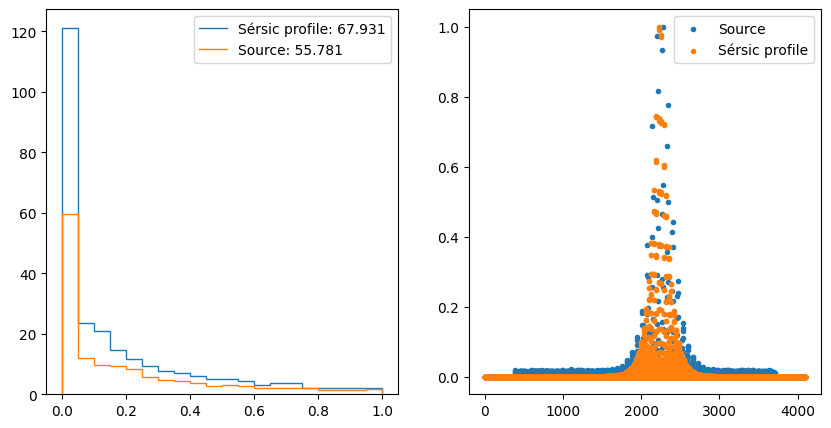

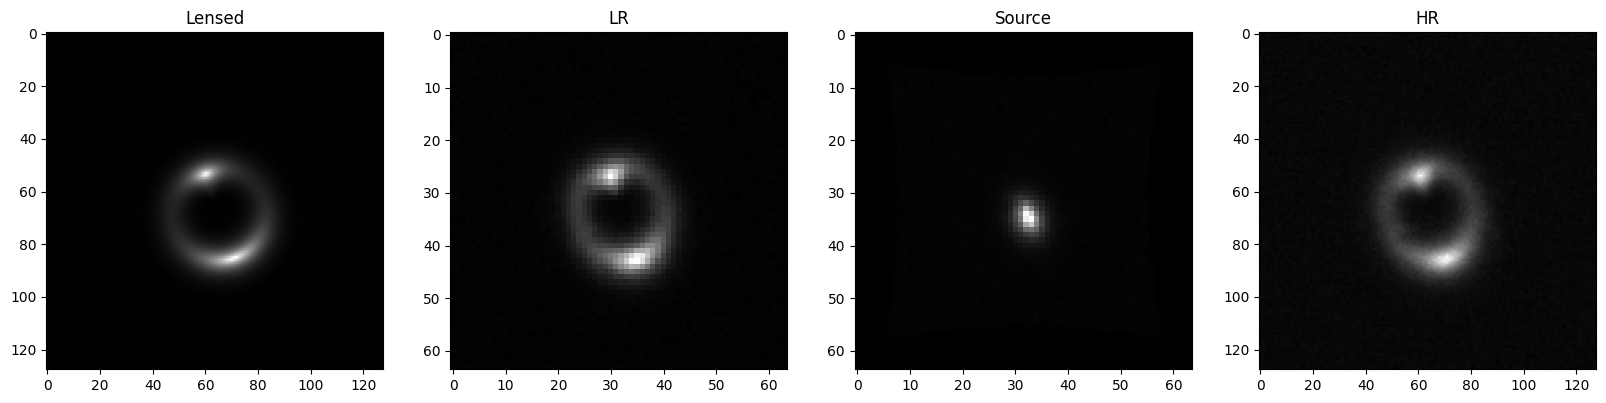

In [7]:
give_image(dataset_cdm, HR_cdm, alpha_model, len(dataset_cdm), plot=True)

In [8]:
def PSNR(mse): 
    """
    Computes the peak-signal to noise ratio

    :param mse: MSE to calculate from
    :return: PSNR value
    """ 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr

from skimage.metrics import structural_similarity
history_no_sub = {'loss':[],'SSIM':[], 'PSNR':[], 'vdl':[]}
history_axion = {'loss':[],'SSIM':[], 'PSNR':[], 'vdl':[]}
history_cdm = {'loss':[],'SSIM':[], 'PSNR':[], 'vdl':[]}

In [9]:
alpha_model.eval()
for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating CDM sub-structure images"):
    image, _, __, HR = give_image(dataset_cdm, HR_cdm, alpha_model, len(dataset_no_sub), i, False, history_cdm)
    loss = torch.nn.functional.mse_loss(image, HR)
    history_cdm['loss'].append(float(loss))
    image, HR = image.cpu().numpy(), HR.cpu().numpy()
    history_cdm['SSIM'].append(structural_similarity(image,
                                                 HR,data_range=1.0))
    history_cdm['PSNR'].append(PSNR(float(loss)))

for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating no sub-structure images"):
    image, _, __, HR = give_image(dataset_no_sub, HR_no_sub, alpha_model, len(dataset_no_sub), i, False, history_no_sub)
    loss = torch.nn.functional.mse_loss(image, HR)
    history_no_sub['loss'].append(float(loss))
    image, HR = image.cpu().numpy(), HR.cpu().numpy()
    history_no_sub['SSIM'].append(structural_similarity(image,
                                                 HR,data_range=1.0))
    history_no_sub['PSNR'].append(PSNR(float(loss)))

for i in tqdm.tqdm(range(len(dataset_no_sub)),desc="Evaluating axion DM sub-structure images"):
    image, _, __, HR = give_image(dataset_axion, HR_axion, alpha_model, len(dataset_no_sub), i, False, history_axion)
    loss = torch.nn.functional.mse_loss(image, HR)
    history_axion['loss'].append(float(loss))
    image, HR = image.cpu().numpy(), HR.cpu().numpy()
    history_axion['SSIM'].append(structural_similarity(image,
                                                 HR,data_range=1.0))
    history_axion['PSNR'].append(PSNR(float(loss)))

Evaluating axion DM sub-structure images: 100%|██████████| 5000/5000 [00:33<00:00, 150.70it/s]


In [10]:
print(f"no_sub: Evaluation completed with \nMSE: {np.mean(history_no_sub['loss'])} ({np.std(history_no_sub['loss'])})\nSSIM: {np.mean(history_no_sub['SSIM'])} ({np.std(history_no_sub['SSIM'])})\nPSNR:  {np.mean(history_no_sub['PSNR'])} ({np.std(history_no_sub['PSNR'])})")
print(f"axion: Evaluation completed with \nMSE: {np.mean(history_axion['loss'])} ({np.std(history_axion['loss'])})\nSSIM: {np.mean(history_axion['SSIM'])} ({np.std(history_axion['SSIM'])})\nPSNR:  {np.mean(history_axion['PSNR'])} ({np.std(history_axion['PSNR'])})")
print(f"cdm: Evaluation completed with \nMSE: {np.mean(history_cdm['loss'])} ({np.std(history_cdm['loss'])})\nSSIM: {np.mean(history_cdm['SSIM'])} ({np.std(history_cdm['SSIM'])})\nPSNR:  {np.mean(history_cdm['PSNR'])} ({np.std(history_cdm['PSNR'])})")

no_sub: Evaluation completed with 
MSE: 0.0029071036788093445 (0.0010268085766740973)
SSIM: 0.22317298846430836 (0.01822411831537857)
PSNR:  25.60298701515078 (1.4068886081633423)
axion: Evaluation completed with 
MSE: 0.002889748177892683 (0.0011049249268781547)
SSIM: 0.22132759678560923 (0.020993863661275054)
PSNR:  25.663485553033116 (1.4997069017614353)
cdm: Evaluation completed with 
MSE: 0.002998344634037378 (0.0011152692910291059)
SSIM: 0.2201812852463201 (0.019291408916652555)
PSNR:  25.483579139407237 (1.4376124857119328)


In [11]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Sub-structure","MSE","SSIM","PSNR","VDL"]
table.add_row(["No_substructure","%0.6f"%np.mean(history_no_sub['loss']),"%0.3f"%np.mean(history_no_sub['SSIM']),"%0.3f"%np.mean(history_no_sub['PSNR']), "%0.3f (%0.3f)"%(np.mean(history_no_sub['vdl']),np.std(history_no_sub['vdl']))])
table.add_row(["Axion (vortex)","%0.6f"%np.mean(history_axion['loss']),"%0.3f"%np.mean(history_axion['SSIM']),"%0.3f"%np.mean(history_axion['PSNR']), "%0.3f (%0.3f)"%(np.mean(history_axion['vdl']),np.std(history_axion['vdl']))])
table.add_row(["CDM (sub-halos)","%0.6f"%np.mean(history_cdm['loss']),"%0.3f"%np.mean(history_cdm['SSIM']),"%0.3f"%np.mean(history_cdm['PSNR']), "%0.3f (%0.3f)"%(np.mean(history_cdm['vdl']),np.std(history_cdm['vdl']))])
print(table)

+-----------------+----------+-------+--------+---------------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |      VDL      |
+-----------------+----------+-------+--------+---------------+
| No_substructure | 0.002907 | 0.223 | 25.603 | 0.000 (0.000) |
|  Axion (vortex) | 0.002890 | 0.221 | 25.663 | 0.000 (0.000) |
| CDM (sub-halos) | 0.002998 | 0.220 | 25.484 | 0.000 (0.000) |
+-----------------+----------+-------+--------+---------------+


In [12]:
"""
Model 1: (finetune)
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.003310 | 0.718 | 25.255 |
|  Axion (vortex) | 0.004801 | 0.660 | 23.506 |
| CDM (sub-halos) | 0.004923 | 0.659 | 23.491 |
+-----------------+----------+-------+--------+

Model 2:
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.002907 | 0.223 | 25.603 |
|  Axion (vortex) | 0.002890 | 0.221 | 25.663 |
| CDM (sub-halos) | 0.002998 | 0.220 | 25.484 |
+-----------------+----------+-------+--------+

Model 3:
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.003158 | 0.787 | 26.728 |
|  Axion (vortex) | 0.003098 | 0.779 | 26.409 |
| CDM (sub-halos) | 0.003133 | 0.779 | 26.486 |
+-----------------+----------+-------+--------+
"""

'\nModel 1: (finetune)\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.003310 | 0.718 | 25.255 |\n|  Axion (vortex) | 0.004801 | 0.660 | 23.506 |\n| CDM (sub-halos) | 0.004923 | 0.659 | 23.491 |\n+-----------------+----------+-------+--------+\n\nModel 2:\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.002907 | 0.223 | 25.603 |\n|  Axion (vortex) | 0.002890 | 0.221 | 25.663 |\n| CDM (sub-halos) | 0.002998 | 0.220 | 25.484 |\n+-----------------+----------+-------+--------+\n\nModel 3:\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.003158 | 0.787 | 26.728 |\n|  Axion (vortex) | 0.003098 | 0.779 | 26.409 |\n| CDM (sub-halos) | 0

In [13]:
""" GAN: 
Model 1:
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.004767 | 0.743 | 24.284 |
|  Axion (vortex) | 0.004097 | 0.750 | 24.854 |
| CDM (sub-halos) | 0.004385 | 0.740 | 24.556 |
+-----------------+----------+-------+--------+

Model 2:
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.003104 | 0.219 | 25.353 |
|  Axion (vortex) | 0.003159 | 0.216 | 25.299 |
| CDM (sub-halos) | 0.003231 | 0.216 | 25.191 |
+-----------------+----------+-------+--------+

Model 3:
+-----------------+----------+-------+--------+
|  Sub-structure  |   MSE    |  SSIM |  PSNR  |
+-----------------+----------+-------+--------+
| No_substructure | 0.001479 | 0.821 | 29.163 |
|  Axion (vortex) | 0.001609 | 0.812 | 28.818 |
| CDM (sub-halos) | 0.001631 | 0.811 | 28.742 |
+-----------------+----------+-------+--------+
"""

' GAN: \nModel 1:\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.004767 | 0.743 | 24.284 |\n|  Axion (vortex) | 0.004097 | 0.750 | 24.854 |\n| CDM (sub-halos) | 0.004385 | 0.740 | 24.556 |\n+-----------------+----------+-------+--------+\n\nModel 2:\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.003104 | 0.219 | 25.353 |\n|  Axion (vortex) | 0.003159 | 0.216 | 25.299 |\n| CDM (sub-halos) | 0.003231 | 0.216 | 25.191 |\n+-----------------+----------+-------+--------+\n\nModel 3:\n+-----------------+----------+-------+--------+\n|  Sub-structure  |   MSE    |  SSIM |  PSNR  |\n+-----------------+----------+-------+--------+\n| No_substructure | 0.001479 | 0.821 | 29.163 |\n|  Axion (vortex) | 0.001609 | 0.812 | 28.818 |\n| CDM (sub-halos) | 0.0016